In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("="*70)
print("GELİŞTİRİLMİŞ POPÜLERİTE SKORU (Playtime Olmadan)")
print("="*70)

# Veriyi yükle
df = pd.read_parquet("eda_data.parquet")
df2 = pd.read_parquet("popularity_score_old.parquet")
df['popularity_score_old'] = df2['popularity_score_old']

# Eski ağırlıklı skoru karşılaştırma için sakla
if 'popularity_score' in df.columns:
    df['popularity_score_old'] = df['popularity_score']
    print("Mevcut popularity_score 'popularity_score_old' olarak kopyalandı.")
else:
    print("Uyarı: 'popularity_score' bulunamadı; sadece yeni skor hesaplanacak.")


GELİŞTİRİLMİŞ POPÜLERİTE SKORU (Playtime Olmadan)
Uyarı: 'popularity_score' bulunamadı; sadece yeni skor hesaplanacak.


In [117]:
# Eksik sütunları hesapla
if 'review_count' not in df.columns:
    df['review_count'] = df['Positive'] + df['Negative']
    print("✓ review_count hesaplandı (Positive + Negative)")

if 'review_quality' not in df.columns:
    df['review_quality'] = df['Positive'] / (df['Positive'] + df['Negative'])
    df['review_quality'] = df['review_quality'].fillna(0)  # Hiç review yoksa 0
    print("✓ review_quality hesaplandı (Positive / Total)")

print(f"\n✓ Veri seti hazır. Şekil: {df.shape}")

✓ review_count hesaplandı (Positive + Negative)
✓ review_quality hesaplandı (Positive / Total)

✓ Veri seti hazır. Şekil: (61432, 46)


## Yeni Ağırlıkların Tanımı

Aşağıdaki ağırlık seti, playtime değişkenini dışarıda bırakarak daha saf bir popülarite ölçüsü üretmeyi hedefler.

- Estimated owners numeric: %40  (kitle büyüklüğü)
- review_count: %35 (ilgi / hacim)
- review_quality: %20 (memnuniyet oranı)
- Achievements: %5 (oyun derinliği / meta etkileşim)


In [118]:
import numpy as np

# Yeni ağırlıklar (playtime hariç)
weights = {
    'Estimated owners numeric': 0.40,
    'review_count': 0.35,
    'review_quality': 0.20,
    'Achievements': 0.05
}

print("Yeni ağırlıklar:")
for f, w in weights.items():
    print(f"  - {f}: {w*100:.0f}%")


Yeni ağırlıklar:
  - Estimated owners numeric: 40%
  - review_count: 35%
  - review_quality: 20%
  - Achievements: 5%


## Skorun Hesaplanması

Özellikler tek tek 0-1 aralığına ölçeklenir (Min-Max) ve ağırlıklarla toplanır. Mevcut normalize sütunlar varsa kullanılır, yoksa yerinde üretilir.

In [119]:
from sklearn.preprocessing import MinMaxScaler

# Normalize edilmiş değerleri kullan (zaten mevcutsa yeniden üretme)
if 'popularity_score_new' in df.columns:
    df.drop(columns=['popularity_score_new'], inplace=True)

df['popularity_score_new'] = 0.0

for feature, weight in weights.items():
    norm_col = f"{feature}_normalized"
    if norm_col in df.columns:
        df['popularity_score_new'] += df[norm_col] * weight
    else:
        # Min-Max normalize et
        col_min = df[feature].min()
        col_max = df[feature].max()
        if col_max == col_min:
            df[norm_col] = 0.0
        else:
            df[norm_col] = (df[feature] - col_min) / (col_max - col_min)
        df['popularity_score_new'] += df[norm_col] * weight

print("Yeni popülerlik skoru hesaplandı.")
print(f"  Min:      {df['popularity_score_new'].min():.4f}")
print(f"  Maks:     {df['popularity_score_new'].max():.4f}")
print(f"  Ortalama: {df['popularity_score_new'].mean():.4f}")
print(f"  Medyan:   {df['popularity_score_new'].median():.4f}")


Yeni popülerlik skoru hesaplandı.
  Min:      0.0000
  Maks:     0.8514
  Ortalama: 0.2510
  Medyan:   0.2439


## Yeni Target Oluşturma

Yeni skora göre Low/Medium/High kesimleri %33'lük quantile'lara göre atanır.

In [120]:
q33_new = df['popularity_score_new'].quantile(0.33)
q66_new = df['popularity_score_new'].quantile(0.66)

df['target_new'] = pd.cut(
    df['popularity_score_new'],
    bins=[-np.inf, q33_new, q66_new, np.inf],
    labels=[0,1,2]
)

print("Yeni target dağılımı:")
print(df['target_new'].value_counts().sort_index())


Yeni target dağılımı:
target_new
0    20581
1    19964
2    20887
Name: count, dtype: int64


## Eski-Yeni Karşılaştırma

Eski skor (playtime dahil) ile yeni skorun (playtime hariç) ayrıştırma gücü ve kategori geçişlerini karşılaştırıyoruz.

Grafik kaydedildi: playtime_comparison.png


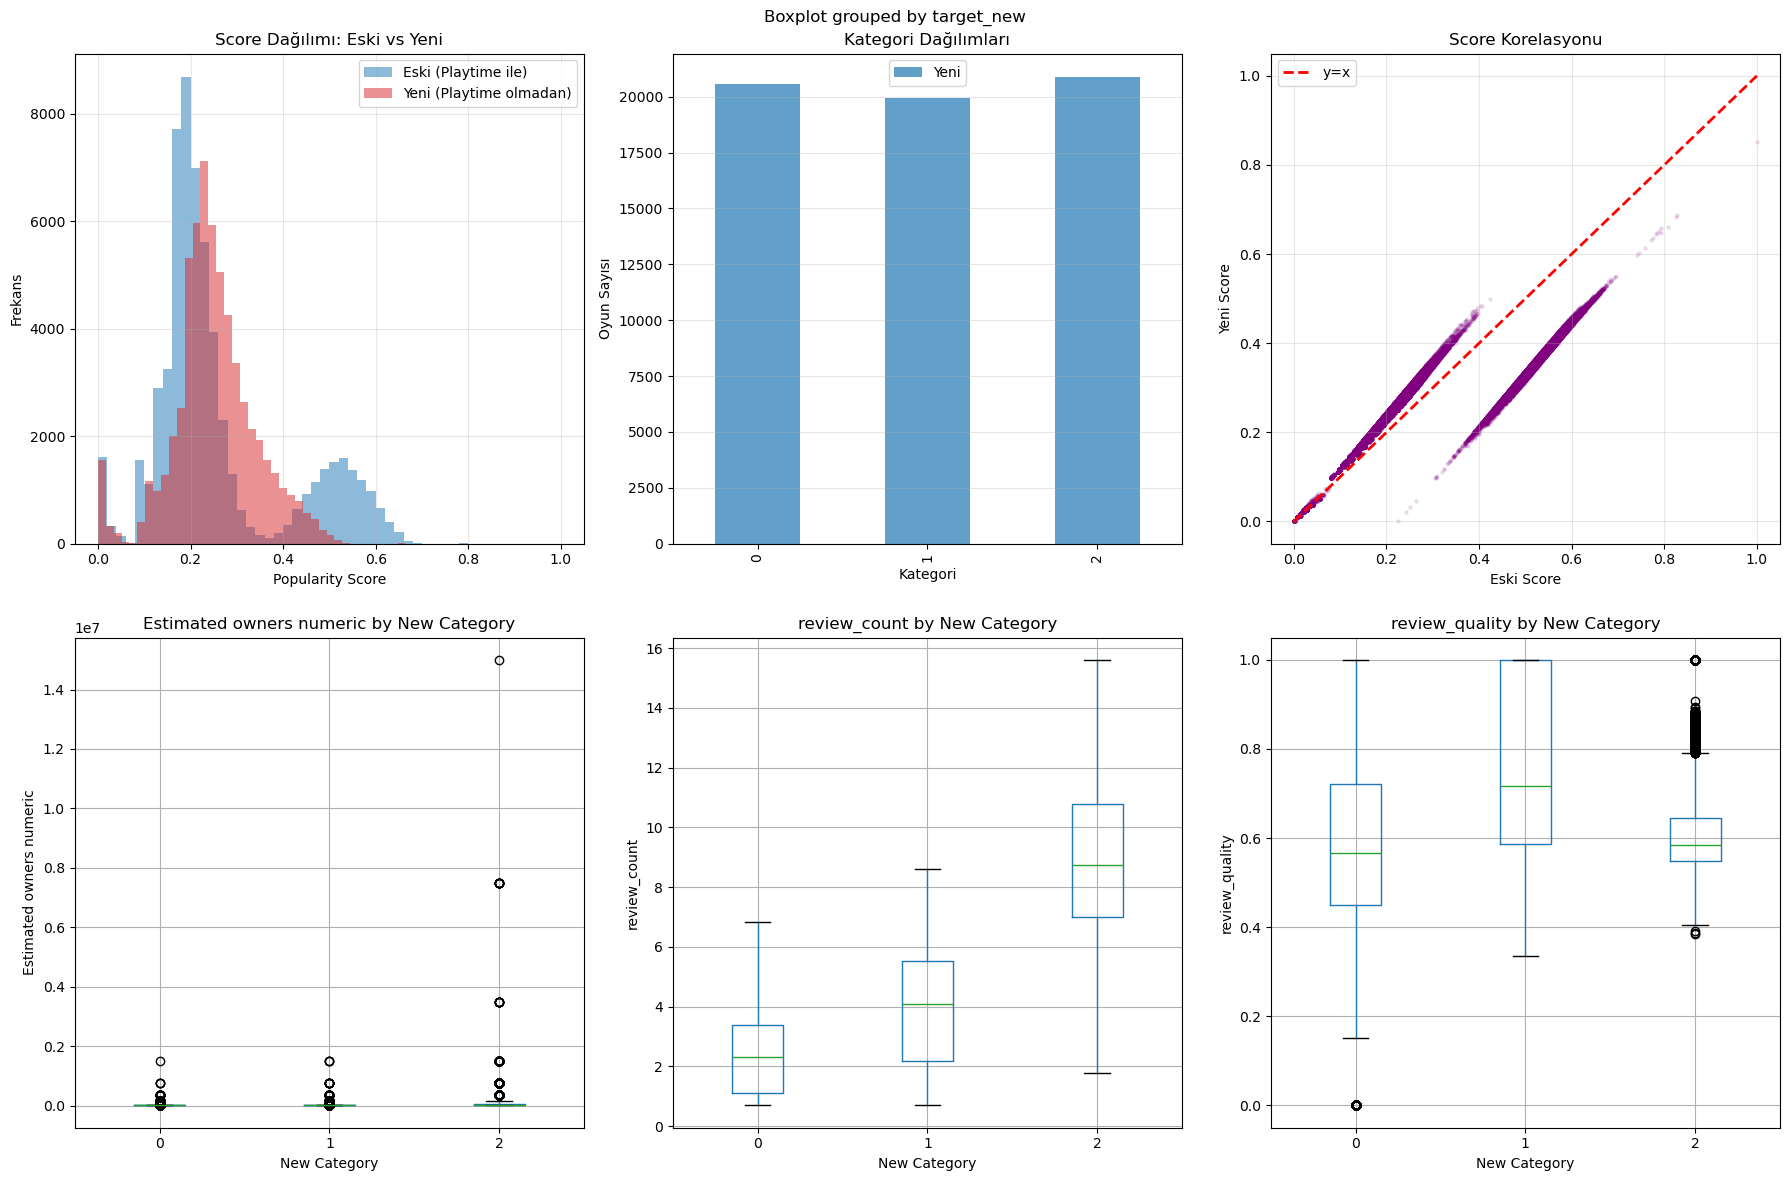

In [121]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Score dağılımı karşılaştırma
if 'popularity_score_old' in df.columns:
    axes[0, 0].hist(df['popularity_score_old'], bins=50, alpha=0.5, label='Eski (Playtime ile)', color='tab:blue')
axes[0, 0].hist(df['popularity_score_new'], bins=50, alpha=0.5, label='Yeni (Playtime olmadan)', color='tab:red')
axes[0, 0].set_xlabel('Popularity Score')
axes[0, 0].set_ylabel('Frekans')
axes[0, 0].set_title('Score Dağılımı: Eski vs Yeni')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Kategori dağılımları
if 'target' in df.columns:
    cat_compare = pd.DataFrame({
        'Eski': df['target'].value_counts().sort_index(),
        'Yeni': df['target_new'].value_counts().sort_index()
    })
else:
    cat_compare = pd.DataFrame({'Yeni': df['target_new'].value_counts().sort_index()})
cat_compare.plot(kind='bar', ax=axes[0, 1], color=['tab:blue', 'tab:red'][:len(cat_compare.columns)], alpha=0.7)
axes[0, 1].set_xlabel('Kategori')
axes[0, 1].set_ylabel('Oyun Sayısı')
axes[0, 1].set_title('Kategori Dağılımları')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3, axis='y')

# 3. Scatter: Eski vs Yeni Score
if 'popularity_score_old' in df.columns:
    axes[0, 2].scatter(df['popularity_score_old'], df['popularity_score_new'], alpha=0.1, s=5, color='purple')
    axes[0, 2].plot([0, 1], [0, 1], 'r--', linewidth=2, label='y=x')
    axes[0, 2].set_xlabel('Eski Score')
    axes[0, 2].set_ylabel('Yeni Score')
    axes[0, 2].set_title('Score Korelasyonu')
    axes[0, 2].legend()
    axes[0, 2].grid(alpha=0.3)
else:
    axes[0, 2].axis('off')

# 4-6. Box plots: Yeni kategorilerin feature dağılımları
features_to_plot = ['Estimated owners numeric', 'review_count', 'review_quality']
for idx, feature in enumerate(features_to_plot):
    ax = axes[1, idx]
    try:
        df.boxplot(column=feature, by='target_new', ax=ax)
        ax.set_title(f'{feature} by New Category')
        ax.set_xlabel('New Category')
        ax.set_ylabel(feature)
        plt.sca(ax)
        plt.xticks(rotation=0)
    except Exception as e:
        ax.text(0.5, 0.5, f'Plotlanamadı: {feature}\n{e}', ha='center', va='center')
        ax.axis('off')

plt.tight_layout()
plt.savefig('playtime_comparison.png', dpi=300, bbox_inches='tight')
print("Grafik kaydedildi: playtime_comparison.png")

## Target(Data) Lakage Önlemi

Target lakage önlemek için target'da kullandığımız özellikleri veri setinden çıkaralım.

In [122]:
# Target'ı oluştururken kullanılan sütunları çıkar (data leakage önleme)
columns_to_drop = [
    'Estimated owners numeric',
    'review_count', 
    'review_quality',
    'Achievements',
    'popularity_score_new',
    'popularity_score_old',
    'popularity_score',
    'target',
    'Estimated owners' # eski target
]

# Normalize edilmiş sütunları da çıkar
normalized_cols = [col for col in df.columns if col.endswith('_normalized')]
columns_to_drop.extend(normalized_cols)

# Mevcut olan sütunları çıkar
cols_to_drop_existing = [col for col in columns_to_drop if col in df.columns]
df_for_modeling = df.drop(columns=cols_to_drop_existing)

print(f"Çıkarılan sütunlar ({len(cols_to_drop_existing)}):")
for col in cols_to_drop_existing:
    print(f"  - {col}")

print(f"\nKalan sütun sayısı: {df_for_modeling.shape[1]}")
print(f"Satır sayısı: {df_for_modeling.shape[0]}")

# Kaydet
output_path = "target1_data.parquet"
cols_to_check = ['target_new']
if all(c in df_for_modeling.columns for c in cols_to_check):
    df_for_modeling.to_parquet(output_path)
    print(f"\n✓ Veri kaydedildi: {output_path}")
    print(f"  Target sütunu: target_new")
    print(f"  Feature sayısı: {df_for_modeling.shape[1] - 1}")  # target hariç
else:
    print("Gerekli sütunlar eksik, kaydetme atlandı.")

Çıkarılan sütunlar (11):
  - Estimated owners numeric
  - review_count
  - review_quality
  - Achievements
  - popularity_score_new
  - popularity_score_old
  - Estimated owners
  - Estimated owners numeric_normalized
  - review_count_normalized
  - review_quality_normalized
  - Achievements_normalized

Kalan sütun sayısı: 41
Satır sayısı: 61432

✓ Veri kaydedildi: target1_data.parquet
  Target sütunu: target_new
  Feature sayısı: 40
